In [5]:
#STEP 1 — Install Libraries
!pip install transformers soundfile datasets


In [6]:
!pip install protobuf==3.20.3 --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [7]:
import os
import pandas as pd
import numpy as np
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm


2025-11-29 16:51:04.106591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764435064.322256      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764435064.398084      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
#STEP 3 — Dataset Root + Load meta_data.csv
DATA_ROOT = "/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2"
META_PATH = os.path.join(DATA_ROOT, "meta_data.csv")

df = pd.read_csv(META_PATH)
print(df.head())


    source target1 target2 method category                 type     race  \
0  id00076       -       -   real        A  RealVideo-RealAudio  African   
1  id00166       -       -   real        A  RealVideo-RealAudio  African   
2  id00173       -       -   real        A  RealVideo-RealAudio  African   
3  id00366       -       -   real        A  RealVideo-RealAudio  African   
4  id00391       -       -   real        A  RealVideo-RealAudio  African   

  gender       path                                         Unnamed: 9  
0    men  00109.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
1    men  00010.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
2    men  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
3    men  00118.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  
4    men  00052.mp4  FakeAVCeleb/RealVideo-RealAudio/African/men/id...  


In [9]:
#STEP 4 — Clean + Fix Columns
# Rename for clarity
df = df.rename(columns={'path': 'filename', 'Unnamed: 9': 'folder_path'})

print("Original folder_path example:")
print(df['folder_path'].head())


Original folder_path example:
0    FakeAVCeleb/RealVideo-RealAudio/African/men/id...
1    FakeAVCeleb/RealVideo-RealAudio/African/men/id...
2    FakeAVCeleb/RealVideo-RealAudio/African/men/id...
3    FakeAVCeleb/RealVideo-RealAudio/African/men/id...
4    FakeAVCeleb/RealVideo-RealAudio/African/men/id...
Name: folder_path, dtype: object


In [10]:
#remove unwanted prefix
df['folder_path'] = df['folder_path'].str.replace(
    "FakeAVCeleb/", "", n=1
)


In [11]:
#STEP 5 — Build Full Video Path
df['video_path'] = df.apply(
    lambda row: os.path.join(DATA_ROOT, row['folder_path'], row['filename']),
    axis=1
)


In [12]:
#cheking for surity
sample = df.sample(1).iloc[0]
print("Video path:", sample['video_path'])
print("Exists:", os.path.exists(sample['video_path']))


Video path: /kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/RealVideo-FakeAudio/Asian (East)/women/id06443/00232_fake.mp4
Exists: True


In [13]:
#STEP 6 — Create Audio Label (0 Real, 1 Fake)
def audio_label_from_type(row):
    if "RealAudio" in row['type']:
        return 0
    else:
        return 1

df['audio_label'] = df.apply(audio_label_from_type, axis=1)
df['audio_label'].value_counts()


audio_label
1    11357
0    10209
Name: count, dtype: int64

In [14]:
#STEP 7 — Keep Only Required Columns
audio_df = df[['video_path', 'audio_label']].copy()
print(len(audio_df), "rows")
audio_df.head()

21566 rows


,video_path,audio_label
0,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
1,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
2,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
3,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0
4,/kaggle/input/fake-ave-celeb/FakeAVCeleb_v1.2/...,0


In [15]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [16]:
#STEP 8 — Train/Validation Split
train_df, val_df = train_test_split(
    audio_df,
    test_size=0.2,
    stratify=audio_df['audio_label'],
    random_state=42
)


In [17]:
#STEP 9 — Wav2Vec2 Feature Extractor
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(
    sampling_rate=16000,
    do_normalize=True,
    return_attention_mask=True
)


In [18]:
#STEP 10 — Audio Dataset Class
class AudioDataset(Dataset):
    def __init__(self, df, feature_extractor, max_length_sec=4):
        self.df = df
        self.feature_extractor = feature_extractor
        self.max_length = 16000 * max_length_sec  # e.g., 4 sec @16kHz

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['video_path']
        label = int(row['audio_label'])

        # Load audio
        audio, sr = torchaudio.load(path)

        # Convert to mono if needed
        if audio.ndim > 1:
            audio = audio.mean(dim=0)
        audio = audio.squeeze(0)  # final shape: [samples]

        # Resample if needed
        if sr != 16000:
            audio = torchaudio.transforms.Resample(sr, 16000)(audio)

        # ---- FIXED LENGTH ----
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            pad_len = self.max_length - len(audio)
            audio = torch.nn.functional.pad(audio, (0, pad_len))

        # Extract features
        inputs = self.feature_extractor(audio, sampling_rate=16000, return_tensors="pt")

        # NOTE: Do NOT squeeze batch dimension if you plan batch>1
        return {
            "input_values": inputs['input_values'].squeeze(0),       # [seq_len]
            "attention_mask": inputs['attention_mask'].squeeze(0),   # [seq_len]
            "labels": torch.tensor(label, dtype=torch.long)
        }

    def __len__(self):
        return len(self.df)



In [19]:
#STEP 11 — Collator (Dynamic Padding)
class DataCollator:
    def __init__(self, feature_extractor):
        self.fe = feature_extractor

    def __call__(self, batch):
        input_values = [item["input_values"] for item in batch]
        attention_mask = [item["attention_mask"] for item in batch]
        labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)

        batch_inputs = self.fe.pad(
            {"input_values": input_values, "attention_mask": attention_mask},
            return_tensors="pt"
        )

        return {
            "input_values": batch_inputs["input_values"].to(device),
            "attention_mask": batch_inputs["attention_mask"].to(device),
            "labels": labels.to(device)
        }

In [20]:
#STEP 12 — Create Dataloaders
train_dataset = AudioDataset(train_df, feature_extractor, max_length_sec=4)
val_dataset   = AudioDataset(val_df, feature_extractor, max_length_sec=4)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,
                          collate_fn=DataCollator(feature_extractor))
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False,
                          collate_fn=DataCollator(feature_extractor))


In [21]:
#STEP 13 — Load Wav2Vec2 Pretrained Model
from transformers import Wav2Vec2ForSequenceClassification
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=2
)
# Freeze encoder
for param in model.wav2vec2.parameters():
    param.requires_grad = False

# Move model to GPU
model.to(device)

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [22]:
#STEP 14 — Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [23]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

/tmp/ipykernel_47/2736003858.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [24]:
#training and validation loop
# training and validation loop (optimized)
EPOCHS = 2

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # TRAIN
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        with autocast():  # mixed precision
            outputs = model(
                input_values=batch["input_values"].to(device),        # <-- GPU tensor
                attention_mask=batch["attention_mask"].to(device),    # <-- GPU tensor
                labels=batch["labels"].to(device)                      # <-- GPU tensor
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == batch["labels"].to(device)).sum().item()  # <-- GPU tensor comparison
        total += batch["labels"].size(0)

    train_loss = total_loss / len(train_loader)
    train_acc  = correct / total

    # VALIDATION
    model.eval()
    val_loss_total = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            outputs = model(
                input_values=batch["input_values"].to(device),        # <-- GPU tensor
                attention_mask=batch["attention_mask"].to(device),    # <-- GPU tensor
                labels=batch["labels"].to(device)                      # <-- GPU tensor
            )
            val_loss_total += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == batch["labels"].to(device)).sum().item()  # <-- GPU tensor comparison
            val_total += batch["labels"].size(0)

    val_loss = val_loss_total / len(val_loader)
    val_acc  = val_correct / val_total

    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")



Epoch 1/2


Training:   0%|          | 0/17252 [00:00<?, ?it/s]/tmp/ipykernel_47/3705657596.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision
Validating: 100%|██████████| 4314/4314 [02:51<00:00, 25.20it/s]


  Train loss: 0.2708 | Train acc: 0.9061
  Val   loss: 0.1001 | Val   acc: 0.9659

Epoch 2/2


Validating: 100%|██████████| 4314/4314 [02:13<00:00, 32.42it/s]

  Train loss: 0.0665 | Train acc: 0.9831
  Val   loss: 0.0486 | Val   acc: 0.9903


In [25]:
#saving the model
# Save the entire model (including architecture + weights)
model.save_pretrained("saved_wav2vec2_model")
# Save the tokenizer/feature extractor as well
feature_extractor.save_pretrained("saved_wav2vec2_model")


['saved_wav2vec2_model/preprocessor_config.json']

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, classification_report
import torchaudio

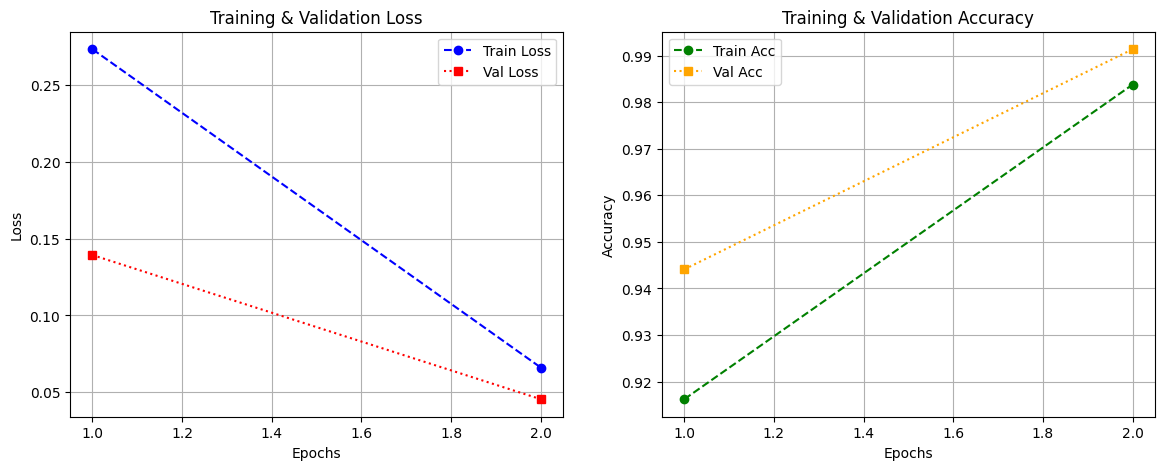

In [28]:
# ------------------ 1. Train/Val Loss & Accuracy ------------------
# --- Store metrics manually in lists ---
train_loss_list = [0.2732, 0.0661]
val_loss_list   = [0.1393, 0.0455]
train_acc_list  = [0.9162, 0.9838]
val_acc_list    = [0.9441, 0.9914]
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list)+1)

plt.figure(figsize=(14,5))

# --- Loss Plot ---
plt.subplot(1,2,1)
plt.plot(epochs, train_loss_list, label='Train Loss', linestyle='--', marker='o', color='blue')
plt.plot(epochs, val_loss_list, label='Val Loss', linestyle=':', marker='s', color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# --- Accuracy Plot ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc_list, label='Train Acc', linestyle='--', marker='o', color='green')
plt.plot(epochs, val_acc_list, label='Val Acc', linestyle=':', marker='s', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [29]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# --- 1. Collect predictions and labels ---
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        input_values = batch["input_values"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(input_values=input_values, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:,1]  # prob for class 1 (fake)
        
        preds = torch.argmax(logits, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)


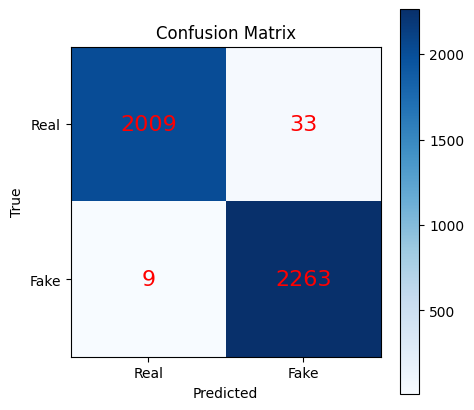

In [30]:
#confusion metrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ['Real','Fake'])
plt.yticks([0,1], ['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red', fontsize=16)
plt.show()

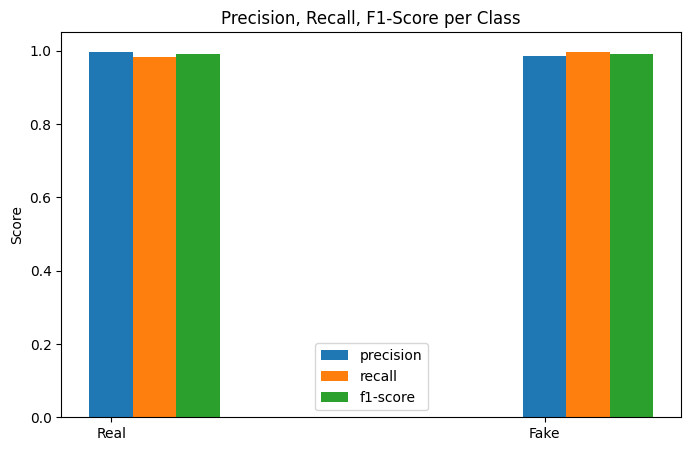

In [38]:
#cllasification report
report = classification_report(all_labels, all_preds, target_names=['Real','Fake'], output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
labels = ['Real', 'Fake']

plt.figure(figsize=(8,5))
for metric in metrics:
    values = [report[label][metric] for label in labels]
    plt.bar([x + 0.1*metrics.index(metric) for x in range(len(labels))], values, width=0.1, label=metric)

plt.xticks(range(len(labels)), labels)
plt.ylim(0,1.05)
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score per Class")
plt.legend()
plt.show()


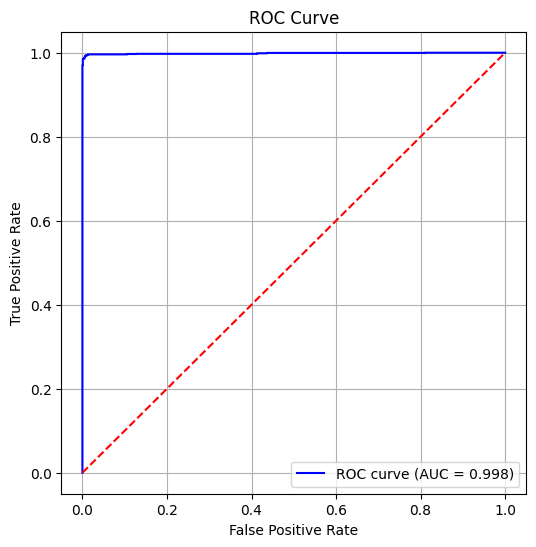

In [39]:
#ROC Curve & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


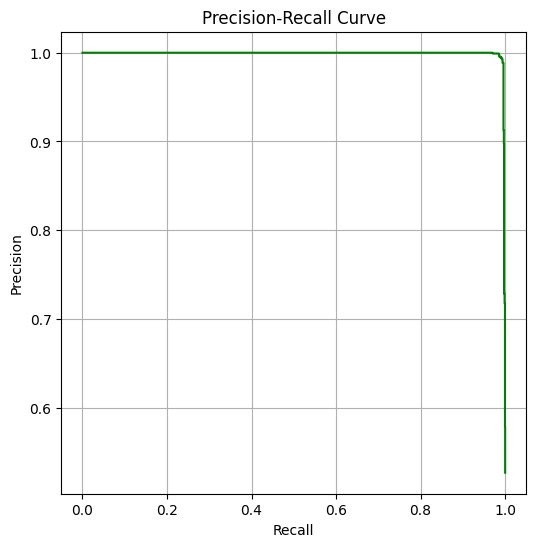

In [40]:
#Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [41]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# --- 1. Generate classification report as dict ---
report = classification_report(all_labels, all_preds, target_names=['Real','Fake'], output_dict=True)

 #--- 2. Convert to DataFrame ---
report_df = pd.DataFrame(report).transpose()
print(report_df)  # exact numbers for all metrics per class

# --- 3. Heatmap to visualize distribution ---
#plt.figure(figsize=(8,6))
#sns.heatmap(report_df.iloc[:-1, :3], annot=True, cmap="YlGnBu", fmt=".2f")  
# iloc[:-1, :3] removes 'accuracy' row and only keeps precision, recall, f1-score
#plt.title("Classification Report Heatmap")
#plt.show()


              precision    recall  f1-score      support
Real           0.995540  0.983839  0.989655  2042.000000
Fake           0.985627  0.996039  0.990806  2272.000000
accuracy       0.990264  0.990264  0.990264     0.990264
macro avg      0.990584  0.989939  0.990230  4314.000000
weighted avg   0.990319  0.990264  0.990261  4314.000000


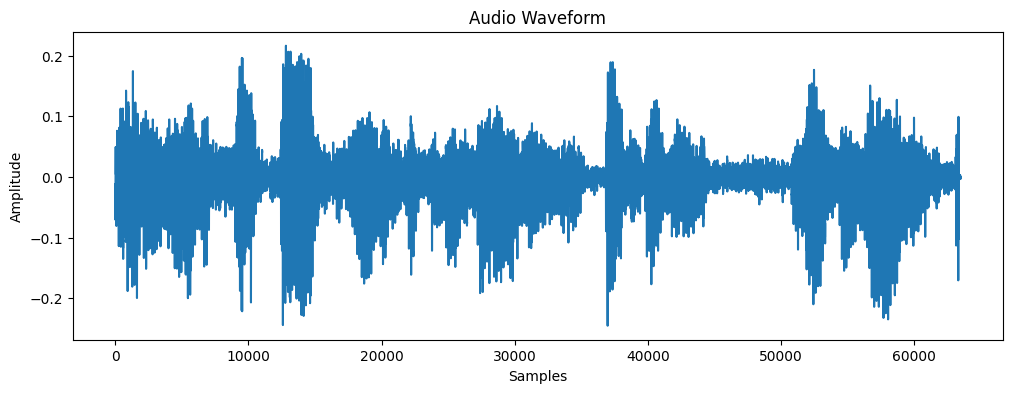

In [42]:
#4. Audio Signal & Spectrogram ------------------
# Pick a random audio from validation set
sample_audio_path = val_df.iloc[0]['video_path']
waveform, sr = torchaudio.load(sample_audio_path)

plt.figure(figsize=(12,4))
plt.plot(waveform.t().numpy())
plt.title("Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


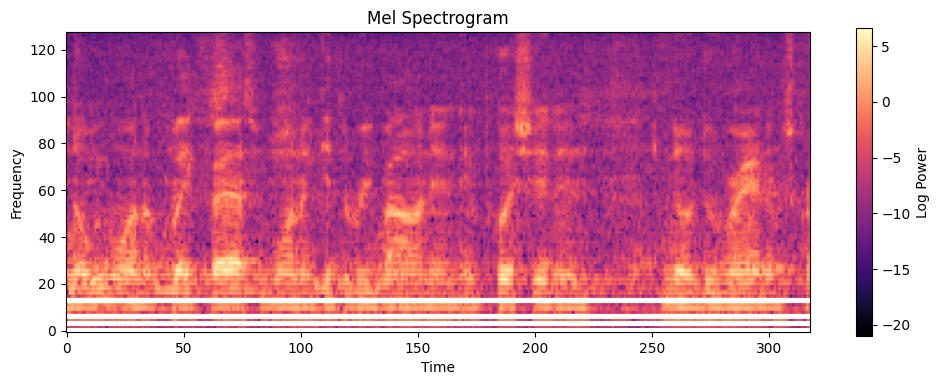

In [43]:
# Spectrogram
#Mel Spectrogram graph se frequency distribution aur voice patterns visualize hoti hain.
spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)
plt.figure(figsize=(12,4))
plt.imshow(spectrogram.log2()[0,:,:].numpy(), cmap='magma', origin='lower')
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Log Power")
plt.show()

In [44]:
import shutil

src_dir = "/kaggle/working/saved_wav2vec2_model"
zip_path = "/kaggle/working/wav2vec2_model.zip"

# Create ZIP
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', src_dir)

print("ZIP created at:", zip_path)


ZIP created at: /kaggle/working/wav2vec2_model.zip


Zip created at: /kaggle/working/wav2vec2_model.zip


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
